In [1]:
import os
import gc
import glob
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from packman import *
from transformers import AutoTokenizer
from tqdm import tqdm
import esm
from esm.models.esm3 import ESM3, EncodeInputs

import esm.pretrained as pretrained

/home/gdwanglab/axk201/.conda/envs/esmfold3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

pretrained.ESM3_structure_decoder_v0 = ESM3
pretrained.ESM3_function_decoder_v0 = ESM3
pretrained.ESM3_structure_encoder_v0 = ESM3

esm_client = torch.load('./in/esm_models/esm3_sm_open_v1_full.pth', weights_only=False, map_location=device)
esm_client = esm_client.float()
esm_client.eval()


ESM3(
  (encoder): EncodeInputs(
    (sequence_embed): Embedding(64, 1536)
    (plddt_projection): Linear(in_features=16, out_features=1536, bias=True)
    (structure_per_res_plddt_projection): Linear(in_features=16, out_features=1536, bias=True)
    (structure_tokens_embed): Embedding(4101, 1536)
    (ss8_embed): Embedding(11, 1536)
    (sasa_embed): Embedding(19, 1536)
    (function_embed): ModuleList(
      (0-7): 8 x Embedding(260, 192, padding_idx=0)
    )
    (residue_embed): EmbeddingBag(1478, 1536, mode='sum', padding_idx=0)
  )
  (transformer): TransformerStack(
    (blocks): ModuleList(
      (0): UnifiedTransformerBlock(
        (attn): MultiHeadAttention(
          (layernorm_qkv): Sequential(
            (0): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=1536, out_features=4608, bias=False)
          )
          (out_proj): Linear(in_features=1536, out_features=1536, bias=False)
          (q_ln): LayerNorm((1536,), eps=1e-05, el

In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
esm_client = torch.load('./in/esm_models/esm2_t6_8M_UR50D.pth', weights_only=False, map_location=device)
esm_client = esm_client.float()
esm_client.eval() 
esm_embed_dim = esm_client.embeddings.word_embeddings.embedding_dim

In [5]:
def pull_ESM_embeddings(sequence: str, llm_model, tokenizer, device):
    """
    Extract per-residue embeddings from a protein sequence using the ESM2 model.
    Returns embeddings with shape [1, seq_len, hidden_dim] and the input_ids.
    """
    tokens = tokenizer(
        sequence,
        return_tensors="pt",
        add_special_tokens=False,   
    ).to(device)
    
    with torch.no_grad():
        outputs = llm_model(**tokens, output_hidden_states=True)
    embeddings = outputs.last_hidden_state.cpu()  
    input_ids = tokens["input_ids"].cpu()
    return embeddings, input_ids



In [6]:
def pull_ESM3_embeddings(sequence: str, llm_model, device):
    """
    Returns per-residue embeddings for a protein sequence using an ESM3 model.
    
    This function leverages the model's built-in tokenizer and directly calls the model's 
    forward method to obtain embeddings. Any special tokens added internally by the tokenizer
    are processed by the model. If you need to remove these later, you may trim the tensor accordingly.
    
    Args:
        sequence (str): Protein sequence (using 1-letter amino acid codes).
        model: An instance of ESM3 that has a `tokenizers` attribute.
        device (torch.device): The device (e.g. 'cpu' or 'cuda') on which to run the model.
    
    Returns:
        torch.Tensor: A tensor of shape [seq_len, hidden_dim] with per-residue embeddings.
    """
    llm_model = llm_model.to(device)
    llm_model.eval()
    encoder = llm_model.encoder

    tokenizer = llm_model.tokenizers.sequence
    tokenized = tokenizer(sequence, return_tensors="pt", add_special_tokens=True)
    sequence_tokens = tokenized["input_ids"].to(device)
    
    with torch.no_grad():
        sequence_embedding = encoder.sequence_embed(sequence_tokens).detach().cpu() 
 
    del tokenized, sequence_tokens
    torch.cuda.empty_cache()
    return sequence_embedding


In [7]:
def extract_chain_sequence(pdb_file):
    mol = molecule.load_pdb(pdb_file)
    sequences = mol.get_sequence().split("\n")

    seq_dict = {
        sequences[i].split("_")[-1]: sequences[i + 1]
                        for i in range(0, len(sequences), 2)
    }

    return seq_dict, mol

In [8]:
regions = {
    "H1": (22, 35),
    "H2": (49, 62),
    "H3": (98, 105),
    "H4": (73, 81),
    "L1": (23, 34),
    "L2": (48, 56),
    "L3": (88, 97),
    "L4": (65, 71)
}

chain_regions = {
    "H": list(range(regions['H1'][0]-1, regions['H1'][1])) +
         list(range(regions['H2'][0]-1, regions['H2'][1])) +
         list(range(regions['H3'][0]-1, regions['H3'][1])) +
         list(range(regions['H4'][0]-1, regions['H4'][1])),

    "L": list(range(regions['L1'][0]-1, regions['L1'][1])) +
         list(range(regions['L2'][0]-1, regions['L2'][1])) +
         list(range(regions['L3'][0]-1, regions['L3'][1])) +
         list(range(regions['L4'][0]-1, regions['L4'][1]))
}

In [9]:
original_pdb = "./in/SPP1_antobody_bound.pdb"
native_seq, native_structure = extract_chain_sequence(original_pdb)

original_heavy_seq = native_seq["H"]
original_light_seq = native_seq["L"]

In [10]:
orig_region_embeddings = {}
full_sequence_embedding = {}
for chain in ["H", "L"]:
    if chain == "H":
        full_seq = original_heavy_seq
    else:
        full_seq = original_light_seq

    emb_full, _ = pull_ESM_embeddings(full_seq, esm_client, tokenizer, device)
    #emb_full = pull_ESM3_embeddings(full_seq, esm_client, device)
    emb_full = emb_full.squeeze(0)  
    full_sequence_embedding[chain] = emb_full 
    
orig_region_embeddings = {}
for region, (start, end) in regions.items():
    if region.startswith("H"):
        emb_full = full_sequence_embedding['H']
    else:
        emb_full = full_sequence_embedding['L']
  
    region_emb = emb_full[start - 1:end]  
    orig_region_embeddings[region] = region_emb  
    
chain_allregion_embeddings = {}
for region, indices in chain_regions.items():
    if region.startswith("H"):
        emb_full = full_sequence_embedding['H']
    else:
        emb_full = full_sequence_embedding['L']
  
    region_emb = emb_full[indices]  
    chain_allregion_embeddings[region] = region_emb 

In [11]:
chain_allregion_embeddings

{'H': tensor([[-0.0975, -0.3289,  0.2315,  ...,  0.3859, -0.1587,  0.1692],
         [-0.1825,  0.0504, -0.4970,  ...,  0.8877, -0.3112, -0.1748],
         [-0.2238, -0.2237,  0.1564,  ...,  0.7774, -0.2175,  0.1233],
         ...,
         [-0.0740, -0.2366, -0.7296,  ...,  1.4966, -0.1395, -0.3294],
         [ 0.6402,  0.6096, -0.1416,  ...,  0.3802,  0.0344,  0.1844],
         [ 0.1620,  0.3149,  0.3318,  ...,  0.4053, -0.3696, -0.4061]]),
 'L': tensor([[-0.2390, -0.2852,  0.1936,  ...,  0.0797, -0.0363,  0.1980],
         [-0.4946, -0.3883, -0.3704,  ...,  0.7427, -0.3797, -0.0149],
         [-0.1117, -0.0643,  0.1351,  ...,  0.6797, -0.0830, -0.0108],
         ...,
         [-0.0574,  0.4993, -0.6752,  ...,  1.2105, -0.5882, -0.2657],
         [ 0.5360,  0.2487, -0.0985,  ...,  0.0251, -0.0070,  0.0296],
         [-0.0634,  0.3975,  0.3830,  ...,  0.1926, -0.4668, -0.1055]])}

In [49]:


import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from torch.nn.functional import cosine_similarity
from tqdm import tqdm  # For progress bar
import torch, os

results = {}
results_chains = {}

all_embedding_vectors = {} 
heavy_embedding_vectors = {} 
light_embedding_vectors = {} 

heavy_embedding_vectors_regions = {}
light_embedding_vectors_regions = {}

chain_embeds = {}
root_dir = "out/antibody_output"
pdb_paths = []
for subdir, _, files in os.walk(root_dir):
    for file in files:
        if file.endswith(".pdb"):
            pdb_paths.append(os.path.join(subdir, file))

for pdb_path in tqdm(pdb_paths, desc="Extracting ESM embeddings", unit="file"):
    file = os.path.basename(pdb_path)
    model_seq, model_structure = extract_chain_sequence(pdb_path)

    if "H" not in model_seq or "L" not in model_seq:
        print(f"Warning: Could not extract H or L chain from {file}. Skipping.")
        continue

    heavy_seq = model_seq["H"]
    light_seq = model_seq["L"]

    region_dists = {}
    region_ident_dists = {}
    region_embeds = []  
    results_chains[pdb_path] = {}

    for region, (start, end) in regions.items():
        orig_seq = original_heavy_seq if region.startswith("H") else original_light_seq
        # Set seq to the proper chain.
        seq = heavy_seq if region.startswith("H") else light_seq
        
        if region.startswith("H"):
            try:
                emb_full = heavy_embedding_vectors[pdb_path]
            except KeyError:
                #emb_full = pull_ESM3_embeddings(heavy_seq, esm_client, device)
                emb_full, _ = pull_ESM_embeddings(heavy_seq, esm_client, tokenizer, device)
                emb_full = emb_full.squeeze(0) 
                heavy_embedding_vectors[pdb_path] = emb_full
                indices = chain_regions['H']
                allregion_embd = emb_full[indices]
                heavy_embedding_vectors_regions[pdb_path] = allregion_embd
                results_chains[pdb_path]["H"] = cosine_similarity(
                    allregion_embd.flatten().unsqueeze(0),
                    chain_allregion_embeddings['H'].cpu().flatten().unsqueeze(0)
                )
        elif region.startswith("L"):
            try:
                emb_full = light_embedding_vectors[pdb_path]
            except KeyError:
                emb_full, _ = pull_ESM_embeddings(heavy_seq, esm_client, tokenizer, device)
                
                #emb_full = pull_ESM3_embeddings(light_seq, esm_client, device)
                emb_full = emb_full.squeeze(0)
                light_embedding_vectors[pdb_path] = emb_full
                indices = chain_regions['L']
                allregion_embd = emb_full[indices]
                light_embedding_vectors_regions[pdb_path] = allregion_embd
                results_chains[pdb_path]["L"] = cosine_similarity(
                    allregion_embd.flatten().unsqueeze(0),
                    chain_allregion_embeddings['L'].cpu().flatten().unsqueeze(0)
                )
                
        if len(seq) < end:
            print(f"Warning: {file} chain {region} too short. Skipping region.")
            continue
        
        region_emb = emb_full[start-1:end]  
        orig_emb = orig_region_embeddings[region]
        common_len = min(region_emb.shape[0], orig_emb.shape[0])
        region_vec = region_emb[:common_len].flatten().detach().cpu()
        orig_vec = orig_emb[:common_len].flatten().detach().cpu()
        similarity = cosine_similarity(region_vec.unsqueeze(0), orig_vec.unsqueeze(0)).item()
        region_dists[region] = 1 - similarity
        
        region_embeds.append(region_emb[:common_len])
        
        
    if region_embeds:
        combined = torch.cat(region_embeds, dim=0)
        flat_vector = combined.flatten().detach().cpu().numpy() 
        all_embedding_vectors[pdb_path] = flat_vector

    results[pdb_path] = region_dists

    torch.cuda.empty_cache()  
    gc.collect()


Extracting ESM embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████████| 2510/2510 [14:25<00:00,  2.90file/s]


In [ ]:
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt

pdb_ids = list(all_embedding_vectors.keys())
X_all = np.array([all_embedding_vectors[pdb] for pdb in pdb_ids])

sorted_regions = sorted(orig_region_embeddings.keys())
orig_embed_list = []
for region in sorted_regions:
    region_orig = orig_region_embeddings[region].flatten().detach().cpu().numpy()
    orig_embed_list.append(region_orig)
    
combined_orig = np.concatenate(orig_embed_list)
combined_orig = combined_orig.reshape(1, -1)

all_dists = []
ref_tensor = torch.from_numpy(combined_orig.flatten())
for pdb in pdb_ids:
    emb_tensor = torch.from_numpy(all_embedding_vectors[pdb])
    sim = torch.nn.functional.cosine_similarity(emb_tensor.unsqueeze(0), ref_tensor.unsqueeze(0)).item()
    dist = 1 - sim
    all_dists.append(dist)

X_all_plus_orig = np.vstack([X_all, combined_orig])
reducer = umap.UMAP(n_components=2, metric="cosine", random_state=42)
umap_coords_all = reducer.fit_transform(X_all_plus_orig)

design_coords_all = umap_coords_all[:-1]  
orig_coord_all   = umap_coords_all[-1]  


In [58]:
import os
import re

rosetta_score = {}
for root, dirs, files in os.walk("./out/antibody_scores"):
    for file in files:
        if file.endswith(".sc"):
            full_path = os.path.join(root, file)
            try:
                with open(full_path, 'r') as f:
                    for line in f:
                        if "SEQUENCE:" in line:
                            continue
                        elif "SCORE: total_score" in line:
                            continue
                            
                        parts = [x for x in line.strip().split() if x!= ""]
                        #print(parts)
                        score = parts[5]  
                        rosetta_score[full_path] = float(score)
                        break  
            except Exception as e:
                continue

reorder_rosetta_score_list = list()
for key, val in all_embedding_vectors.items():
    try:
        key_parts = key.split("/")
        score_key = "./out/antibody_scores/"+key_parts[2]+"/"+key_parts[3].rstrip(".pdb")+"_score.sc"
        reorder_rosetta_score_list.append(rosetta_score[score_key])
    except:
        continue


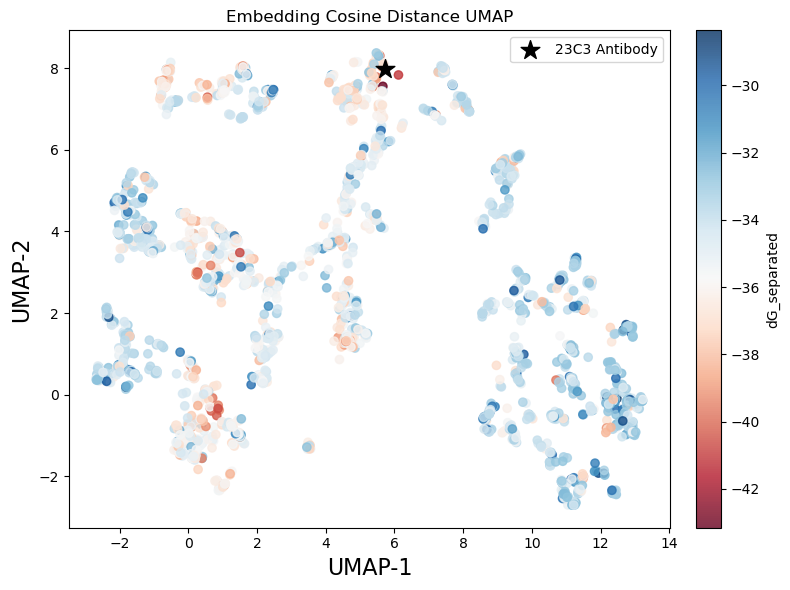

In [71]:
plt.figure(figsize=(8, 6))

sc = plt.scatter(design_coords_all[:, 0], design_coords_all[:, 1],
                 c=reorder_rosetta_score_list, cmap="RdBu", alpha=0.8)

plt.scatter(orig_coord_all[0], orig_coord_all[1], marker='*', color='black', s=200, label='23C3 Antibody')

plt.title("Embedding Cosine Distance UMAP")
plt.xlabel("UMAP-1", fontsize=16)
plt.ylabel("UMAP-2", fontsize=16)
plt.legend(loc="best")
plt.colorbar(sc, fraction=0.046, pad=0.04, label="dG_separated")
plt.tight_layout()
plt.savefig("umap_all_combined_helix_embeddings.png", dpi=300)
plt.show()

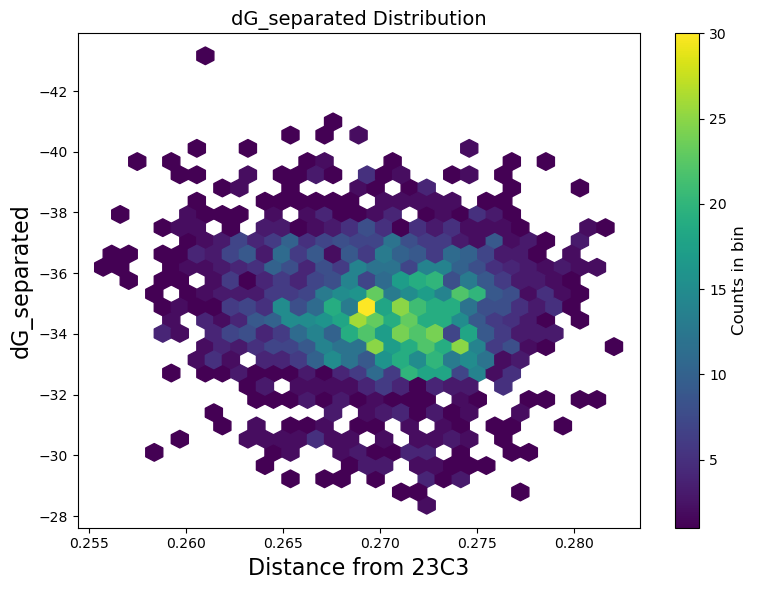

In [ ]:
import matplotlib.pyplot as plt

filtered_cosine = all_dists
binding_energies = reorder_rosetta_score_list 

plt.figure(figsize=(8, 6))
hb = plt.hexbin(filtered_cosine, binding_energies, gridsize=30, cmap='viridis', mincnt=1)
cb = plt.colorbar(hb)
cb.set_label('Counts in bin', fontsize=12)
plt.xlabel("Distance from 23C3", fontsize=16)
plt.ylabel("dG_separated", fontsize=16)
plt.title("dG_separated Distribution", fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("hexbin_cosine_vs_dG_separated_heavy.png", dpi=300)
plt.show()


In [82]:
list(sorted(rosetta_score.items(), key=lambda item: item[1]))[:5]

[('./out/antibody_scores/seq_evolve_norm24/spp1_rabd_SPP1_antobody_bound_0079_score.sc',
  -43.159),
 ('./out/antibody_scores/seq_evolve_norm15/spp1_rabd_SPP1_antobody_bound_0093_score.sc',
  -41.046),
 ('./out/antibody_scores/seq_evolve_norm17/spp1_rabd_SPP1_antobody_bound_0070_score.sc',
  -40.706),
 ('./out/antibody_scores/seq_evolve_norm2/spp1_rabd_SPP1_antobody_bound_0081_score.sc',
  -40.614),
 ('./out/antibody_scores/seq_evolve_norm8/spp1_rabd_SPP1_antobody_bound_0035_score.sc',
  -40.516)]